In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import glob
import numpy as np
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import metpy.units as units
from scipy.ndimage import uniform_filter
import wrf
import netCDF4 as nc
import tqdm
import pandas as pd
import cartopy
import shapely
from cartopy import geodesic
from scipy.ndimage import gaussian_filter

In [2]:
def latlon_dist(lat, lon, lats, lons):

        #Calculate great circle distance (Harversine) between a lat lon point (lat, lon) and a list of lat lon
        # points (lats, lons)
                        
        R = 6373.0
                        
        lat1 = np.deg2rad(lat)
        lon1 = np.deg2rad(lon)
        lat2 = np.deg2rad(lats)
        lon2 = np.deg2rad(lons)
                
        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

        return (R * c)

def synoptic_diagnostics(domain, time, wb_hgt=850, smoothing=4):

    lon1, lat1, lon2, lat2 = domain

    #Calculate the wet bulb potential temperature gradient
    fq=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/q/"+time.strftime("%Y")+"/q_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                   .sel({"time":time.replace(minute=0), "level":slice(wb_hgt,wb_hgt)}).sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)}).metpy.assign_crs(grid_mapping_name='latitude_longitude').q#.metpy.parse_cf("q")
    ft=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/t/"+time.strftime("%Y")+"/t_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                   .sel({"time":time.replace(minute=0), "level":slice(wb_hgt,wb_hgt)}).sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)}).metpy.assign_crs(grid_mapping_name='latitude_longitude').t#.metpy.parse_cf("t")
    fdp = mpcalc.dewpoint_from_specific_humidity(wb_hgt*units.units.hectopascal, ft, fq)

    p3d = xr.DataArray(data = np.ones(ft.shape) * wb_hgt*100, coords=ft.coords, dims=ft.dims, attrs={"units":"Pa"})
    wb = wrf.wetbulb(p3d, ft, fq, meta=True)
    wb_pot = mpcalc.potential_temperature(p3d, wb).isel({"level":0})
    dlat, dlon = mpcalc.gradient(wb_pot.coarsen({"latitude":smoothing, "longitude":smoothing},boundary="pad").mean())
    wb_pot_grad = np.sqrt(np.square(dlat) + np.square(dlon)).metpy.convert_units("K/km")

    #Calculate the 500 hPa geostrophic vorticity
    fz=xr.open_dataset(glob.glob("/g/data/rt52/era5/pressure-levels/reanalysis/z/"+time.strftime("%Y")+"/z_era5_oper_pl_"+time.strftime("%Y%m")+"*.nc")[0])\
                .sel({"time":time.replace(minute=0), "level":slice(500,500)})\
                .sel({"longitude":slice(lon1,lon2), "latitude":slice(lat2,lat1)})\
                .metpy.assign_crs(grid_mapping_name='latitude_longitude').z\
                .coarsen({"latitude":smoothing, "longitude":smoothing}, boundary="pad").mean().isel({"level":0})
    lons, lats = np.meshgrid(fz.longitude, fz.latitude)
    f=mpcalc.coriolis_parameter(lats * units.units.degree)
    laplacian = (mpcalc.laplacian(fz) / f)
    
    return wb_pot_grad, laplacian

def get_point_data(f,lat,lon,r,plot=False,vmin=None,vmax=None,func="abs"):
    lats = f.coords.get("latitude").values
    lons = f.coords.get("longitude").values
    x,y = np.meshgrid(lons,lats)
    dist_km = (latlon_dist(lat, lon, y, x) )
    a,b = np.where( (dist_km <= r) )
    target_lons = xr.DataArray(lons[b],dims="points")
    target_lats = xr.DataArray(lats[a],dims="points")    
    f_slice = (f.sel(longitude=target_lons, latitude=target_lats))
    
    if plot:
        plt.figure()
        ax=plt.axes(projection=ccrs.PlateCarree())
        temp = np.where((dist_km <= r), f.values, np.nan)
        c=ax.pcolormesh(x,y,temp,vmin=vmin,vmax=vmax)
        plt.colorbar(c)
        ax.coastlines()
    
    if func=="abs":
        #Return the value of the point with the highest absolute value
        return f_slice.values[np.abs(f_slice).argmax()]
    elif func=="max":
        #Return the maximum value
        return f_slice.values.max()
    elif func=="min":
        #Return the minimum value
        return f_slice.values.min()

In [3]:
lon1 = 120; lat1 = -44.5; lon2 = 160; lat2 = -15
domain = [lon1,lat1,lon2,lat2]
r=500
wb_hgt=700

details_list = [\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2006,9,24,1,41)], "rid":"Melbourne", "title":"a) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2009,11,20,3,6)], "rid":"Melbourne", "title":"b) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,3,6,3,30)], "rid":"Melbourne", "title":"c) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2010,6,17,0,25)], "rid":"Melbourne", "title":"d) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,11,18,7,4)], "rid":"Melbourne", "title":"e) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2011,12,25,6,45)], "rid":"Melbourne", "title":"f) Melbourne:  UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2012,2,26,9,11)], "rid":"Melbourne", "title":"g) Melbourne:  UTC"},\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2013,3,21,3,45)], "rid":"Melbourne", "title":"h) Melbourne: UTC" },\
        {"lat":-37.6654, "lon":144.8322, "time" : [dt.datetime(2015,2,28,9,25)], "rid":"Melbourne", "title":"i) Melbourne:  UTC"},\
       \
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2010,8,2,15,43)], "rid":"Sydney", "title":"a) Sydney:  UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2012,8,10,4,21)], "rid":"Sydney", "title":"b) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2013,2,23,13,43)], "rid":"Sydney", "title":"c) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2014,10,14,11,39)], "rid":"Sydney", "title":"d) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,3,1,4,34)], "rid":"Sydney", "title":"e) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2015,12,16,2,3)], "rid":"Sydney", "title":"f) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,1,14,4,20)], "rid":"Sydney", "title":"g) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2016,6,4,3,42)], "rid":"Sydney", "title":"h) Sydney: UTC"},\
        {"lat":-33.9465, "lon":151.1731, "time" : [dt.datetime(2017,4,9,8,3)], "rid":"Sydney", "title":"i) Sydney: UTC"},\
       \
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2010,12,16,3,25)], "rid":"Amberley", "title":"a) Amberley: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2011,1,18,5,5)], "rid":"Amberley", "title":"b) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2011,10,7,19,22)], "rid":"Amberley", "title":"c) Oakey: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2013,10,18,4,4)], "rid":"Amberley", "title":"d) Oakey: UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2013,11,23,9,45)], "rid":"Amberley", "title":"e) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2014,1,23,4,52)], "rid":"Amberley", "title":"f) Oakey UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2016,1,29,4,22)], "rid":"Amberley", "title":"g) Oakey UTC"},\
        {"lat":-27.6297, "lon":152.7111, "time" : [dt.datetime(2016,12,18,4,14)], "rid":"Amberley", "title":"h) Amberley: UTC"},\
        {"lat":-27.4034, "lon":151.7413, "time" : [dt.datetime(2018,2,13,7,5)], "rid":"Amberley", "title":"i) Oakey: UTC"},\
       \
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2007,10,27,9,3)], "rid":"Woomera", "title":"a) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2008,12,9,6,18)], "rid":"Woomera", "title":"b) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2010,12,7,9,27)], "rid":"Woomera", "title":"c) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2011,11,8,9,47)], "rid":"Woomera", "title":"d) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,1,29,4,42)], "rid":"Woomera", "title":"e) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2012,11,30,8,33)], "rid":"Woomera", "title":"f) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2014,10,31,7,52)], "rid":"Woomera", "title":"g) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2015,12,7,11,20)], "rid":"Woomera", "title":"h) "},\
        {"lat":-31.1558, "lon":136.8054, "time" : [dt.datetime(2017,12,18,11,30)], "rid":"Woomera", "title":"i) "},\
         ]

import warnings
warnings.simplefilter("ignore")
rids = []
times = []
laplacians = []
wb_grads = []
lats = []
lons = []
for details in tqdm.tqdm(details_list):
    time = details["time"][0].replace(minute=0)
    wb_pot_grad, laplacian = synoptic_diagnostics(domain, time, wb_hgt=wb_hgt, smoothing=4)
    laplacians.append(get_point_data(laplacian,details["lat"],details["lon"],r,func="min"))
    wb_grads.append(get_point_data(wb_pot_grad,details["lat"],details["lon"],r,func="max"))    
    times.append(time)
    rids.append(details["rid"])
    lats.append(details["lat"])
    lons.append(details["lon"])
df = pd.DataFrame({"rid":rids, "laplacian":laplacians, "wb_grad":wb_grads, "lat":lats, "lon":lons}, index=times)
df.to_csv("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/synop_stats.csv")

#TODO: Consider coarsening the geopotential grid, before doing the Laplacian (rather than rolling mean)
#Incorperate time dimension and chunk for systematic application

100%|██████████| 36/36 [00:32<00:00,  1.11it/s]


[0.001 0.004 0.014 0.024 0.034 0.044 0.054]
[0.001 0.004 0.014 0.024 0.034 0.044 0.054]


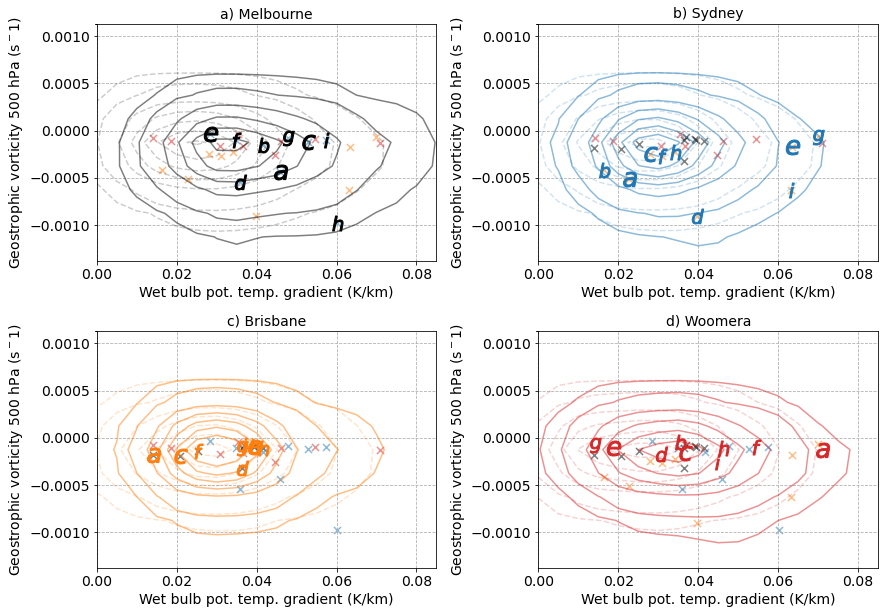

In [9]:
import matplotlib

plt.figure(figsize=[14,10])
cnt=1
letter = ["a","b","c","d","e","f","g","h","i"]
letter_cols = ["k","tab:blue","tab:orange","tab:red"]
locs = [["Melbourne"], ["Sydney"], ["Amberley","Oakey"],["Woomera"]]
titles = ["a) Melbourne", "b) Sydney", "c) Brisbane", "d) Woomera"]
clim = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/points/era5_synoptic_"+str(r)+"km_wb"+str(wb_hgt)+"_smoothing4_2005_2018.csv")
clim["time"] = pd.DatetimeIndex(clim["time"])
l = pd.read_pickle("/g/data/eg3/ab4502/ExtremeWind/ad_data/lightning_aus_50.pkl")
clim=l.merge(clim,how="inner",left_on=["date","loc_id"],right_on=["time","loc"])



for i in np.arange(len(locs)):
    ax=plt.subplot(2,2,cnt)
    
    wb = df[np.in1d(df["rid"],locs[cnt-1])]["wb_grad"].values
    laplacian = df[np.in1d(df["rid"],locs[cnt-1])]["laplacian"].values    
    for i in np.arange(len(wb)):
            plt.plot(wb[i],laplacian[i],marker="$"+letter[i]+"$",ls="none",color=letter_cols[cnt-1],ms=15,mew=1)

    cnt2=0
    for n, g in df.groupby("rid"):
        if cnt2==(cnt-1):
            pass
        else:
            wb = g["wb_grad"].values
            laplacian = g["laplacian"].values    
            plt.scatter(wb,laplacian,color=letter_cols[cnt2],alpha=0.5,s=50,marker="x")
        cnt2=cnt2+1
            
    plt.xlabel("Wet bulb pot. temp. gradient (K/km)",size=14)
    plt.ylabel("Geostrophic vorticity 500 hPa (s${^-1}$)",size=14)
    plt.gca().grid(ls="--")


    #CLIM PLOT
    c_levels = np.insert(np.arange(0.004,0.064,0.01), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning<2").wb_pot_grad.values, clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning<2").laplacian.values, 
                           bins=[ np.arange(-0.0025,0.105,0.005), np.arange(-0.0015,0.0015,0.00025)])
    H = gaussian_filter(H,1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=ax.contour(x,y,H.T/(H.sum()), levels=c_levels,alpha=0.2,colors=letter_cols[cnt-1],linestyles="--")
    # labs = plt.clabel(c, c_levels[1::2])
    # [l.set_alpha(1) for l in labs]
    # labs = plt.clabel(c, [c_levels[0]])
    # [l.set_alpha(1) for l in labs]
    
    ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(subs="all"))
    
    ax.set_xlim([0,0.085])
    ax.tick_params(labelsize=14)
    plt.title(titles[cnt-1],size=14)
    
    cnt=cnt+1    
print(c_levels)
    
cnt=1
for i in np.arange(len(locs)):
    ax=plt.subplot(2,2,cnt)

    #CLIM PLOT
    c_levels = np.insert(np.arange(0.004,0.064,0.01), 0, [0.001])
    H, xe, ye = np.histogram2d(clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning>=2").wb_pot_grad.values, clim[np.in1d(clim["loc"],locs[cnt-1])].query("lightning>=2").laplacian.values, 
                           bins=[ np.arange(-0.0025,0.105,0.005), np.arange(-0.0015,0.0015,0.00025)])
    H = gaussian_filter(H,1)
    x,y = np.meshgrid(([(xe[i] + xe[i+1])/2. for i in np.arange(len(xe)-1)]), ([(ye[i] + ye[i+1])/2. for i in np.arange(len(ye)-1)]))
    c=ax.contour(x,y,H.T/(H.sum()), levels=c_levels,alpha=0.5,colors=letter_cols[cnt-1])
    # labs = plt.clabel(c, c_levels[1::2])
    # [l.set_alpha(1) for l in labs]
    # labs = plt.clabel(c, [c_levels[0]])
    # [l.set_alpha(1) for l in labs]
    
    cnt=cnt+1  
print(c_levels)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.savefig("/g/data/eg3/ab4502/figs/ExtremeWind/case_studies/wb_laplacian_clim_lightning_"+str(r)+"_"+str(wb_hgt)+".jpeg",bbox_inches="tight",quality=95)

100%|██████████| 36/36 [00:10<00:00,  3.51it/s]


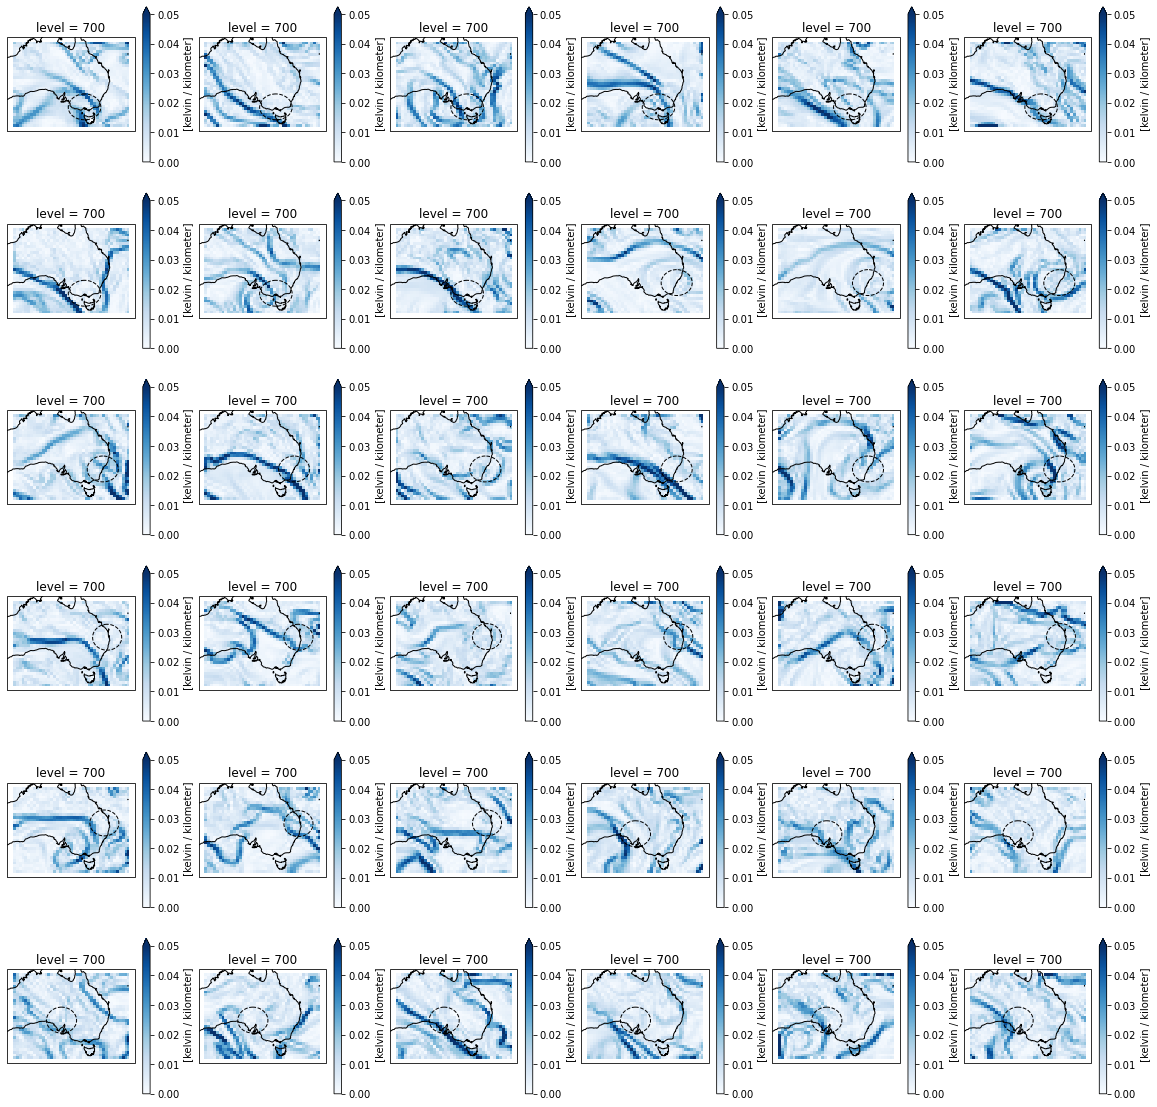

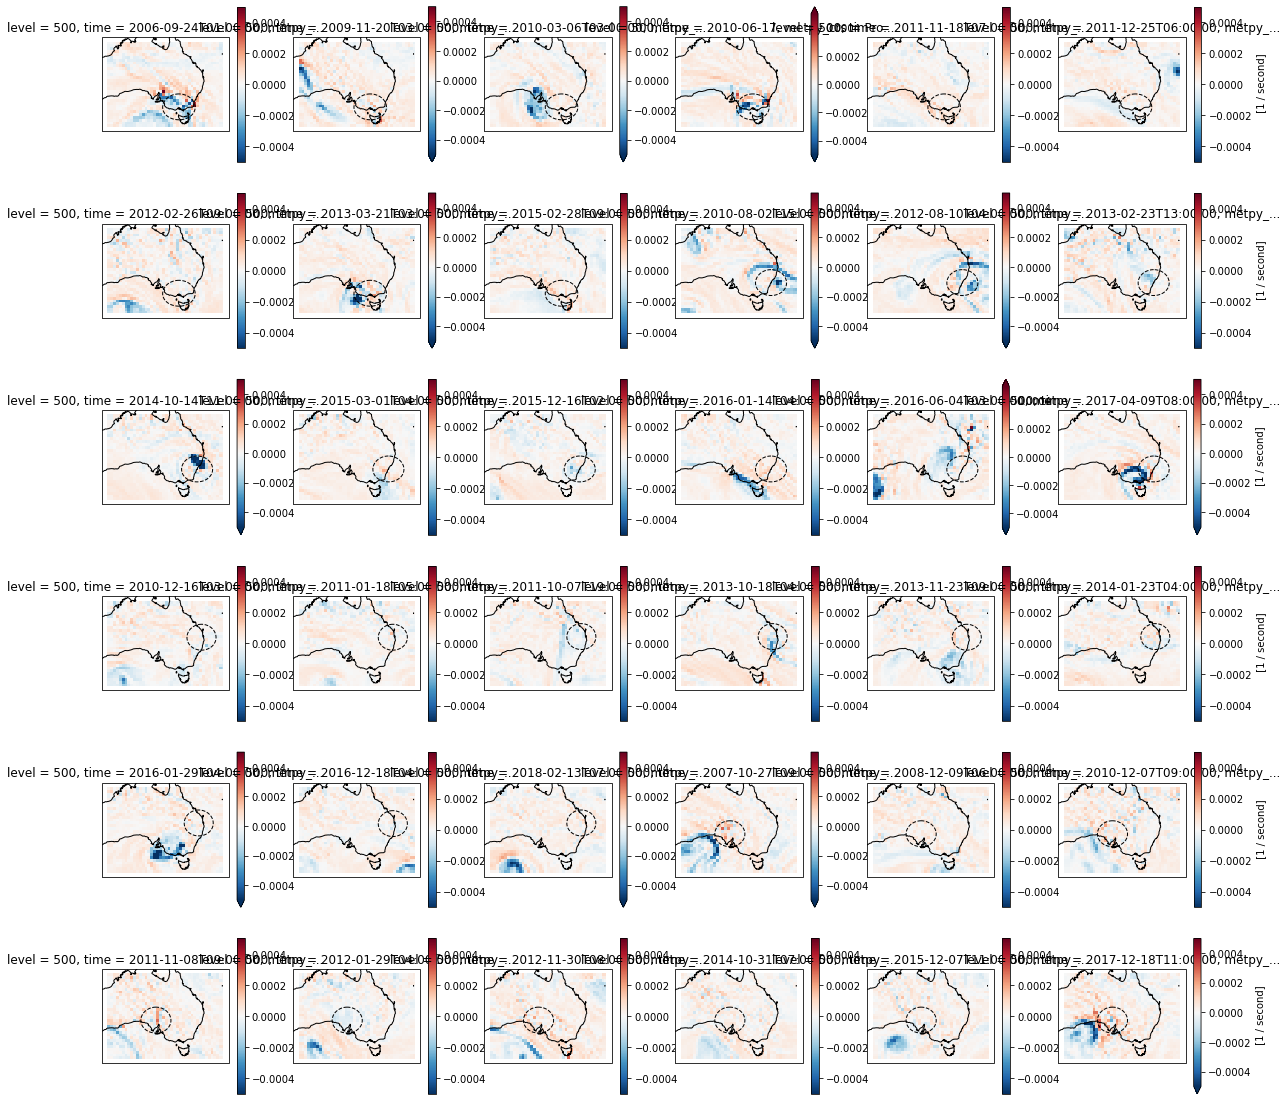

In [5]:
wb_hgt=700
r=500

cnt=1
plt.figure(figsize=[20,20])
for d in tqdm.tqdm(details_list):

        wb_pot_grad, laplacian = synoptic_diagnostics(domain, d["time"][0], wb_hgt=wb_hgt, smoothing=4)
    
        ax=plt.subplot(6,6,cnt,projection=ccrs.PlateCarree())
        wb_pot_grad.plot(ax=ax,vmin=0,vmax=0.05,cmap=plt.get_cmap("Blues"))
        ax.coastlines()
        circle_points = geodesic.Geodesic().circle(d["lon"], d["lat"], r*1000)
        geom = shapely.geometry.Polygon(circle_points)
        ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1,ls="--")
        cnt=cnt+1
        
cnt=1
plt.figure(figsize=[20,20])
for d in tqdm.tqdm(details_list):
    
        wb_pot_grad, laplacian = synoptic_diagnostics(domain, d["time"][0], wb_hgt=wb_hgt, smoothing=4)

        ax=plt.subplot(6,6,cnt,projection=ccrs.PlateCarree())
        laplacian.plot(ax=ax,vmin=-0.0005,vmax=0.0005,cmap=plt.get_cmap("RdBu_r"))
        ax.coastlines()
        circle_points = geodesic.Geodesic().circle(d["lon"], d["lat"], r*1000)
        geom = shapely.geometry.Polygon(circle_points)
        ax.add_geometries((geom,), crs=cartopy.crs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=1,ls="--")
        cnt=cnt+1

        # print(get_point_data(wb_pot_grad,details_list[i]["lat"], details_list[i]["lon"],500,plot=True,vmin=0,vmax=0.05))
        # print(get_point_data(laplacian,details_list[i]["lat"], details_list[i]["lon"],500,plot=True,vmin=-0.0005,vmax=0.0005))